In [1]:
# import tools
import pandas as pd
%matplotlib inline
import qiime2
from qiime2 import Artifact
from tempfile import mkdtemp
from qiime2.plugins import demux, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition
from qiime2.plugins import fragment_insertion
from qiime2.plugins.fragment_insertion.methods import filter_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.visualizers import summarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy.optimize import curve_fit

## Import data

In [2]:
# import raw feature table and taxonomy
table = Artifact.load('96057_feature-table.qza')
taxonomy = Artifact.load('96057_reference-hit.taxonomy_gg.qza')

## Collapse and subset data

In [3]:
# collapsed table to genus level
t6 = taxa.methods.collapse(table = table,
                           taxonomy = taxonomy,
                           level = 6)
# import collapsed table as pandas dataframe
df = t6.collapsed_table.view(pd.DataFrame)
# subset out Zymo mock community samples
zymo = df[df.index.str.contains('Zymo')]
# ensure table values are numeric
zymo = zymo.astype(float)

In [4]:
# quick visual check that top 8 taxa make up most of the reads in highest input sample (well A7)
max_input = zymo[zymo.index.str.contains("A7")]
zymoT = max_input.T
zymoT.sort_values(zymoT.columns[0], ascending = False).head(10)

,13092.v2.06.ZymoMock.A7,13092.v2.13.ZymoMock.A7,13092.v2.05.ZymoMock.A7,13092.v2.14.ZymoMock.A7
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__,49798.0,33220.0,46877.0,39241.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus,12121.0,9014.0,12239.0,9477.0
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas,8525.0,3420.0,7846.0,8769.0
k__Bacteria;p__Firmicutes;c__Bacilli;__;__;__,7528.0,5928.0,7321.0,6265.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus,6197.0,4910.0,6306.0,4676.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,4895.0,4461.0,5415.0,3018.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria,2735.0,2302.0,2894.0,2319.0
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium,21.0,10.0,20.0,49.0
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides,15.0,12.0,21.0,23.0
k__Bacteria;__;__;__;__;__,8.0,6.0,0.0,0.0


## Caluclate reads aligning to mock community

In [5]:
# Calculate the total number of reads per sample
zymo['deblur_reads'] = zymo.sum(axis=1)
# calculate the number of reads aligning to the mock community input genera
zymo['zymo_reads'] = zymo[['k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus',
       'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas',
       'k__Bacteria;p__Firmicutes;c__Bacilli;__;__;__',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria']].sum(axis=1)
# calculate the percent correctly assigned
zymo['correct_assign'] = zymo['zymo_reads'] / zymo['deblur_reads']

In [6]:
# subset out KatharoSeq columns and add in logarithim of reads for plotting
katharo = zymo[['correct_assign','deblur_reads','zymo_reads']]
katharo['log_deblur_reads'] = np.log10(katharo['deblur_reads'])

/Users/lisamarotz/miniconda2/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Fit an allosteric sigmoid curve for extrpolating min read count #

[   9.65346947 4357.45360311]


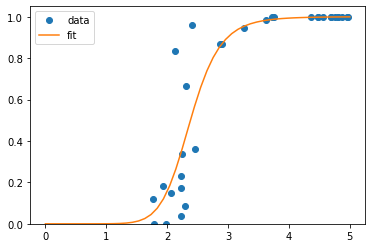

In [7]:
# define the allosteric sigmoid equation
def allosteric_sigmoid(x, h, k_prime):
    y = x ** h / (k_prime + x ** h)
    return y
 
# fit the curve to your data
popt, pcov = curve_fit(allosteric_sigmoid, katharo['log_deblur_reads'], katharo['correct_assign'], method='dogbox')
print(popt)
# plot fit curve
x = np.linspace(0, 5, 50)
y = allosteric_sigmoid(x, *popt)

# plot the fit
pylab.plot(katharo['log_deblur_reads'], katharo['correct_assign'], 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [8]:
# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.5 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_50 = np.power(10, min_log_reads).astype(int)
min_freq_50

241

In [9]:
# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.8 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_80 = np.power(10, min_log_reads).astype(int)
min_freq_80

562

In [10]:
# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.9 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_90 = np.power(10, min_log_reads).astype(int)
min_freq_90

979

## Remove samples with less than Katharoseq read limit

In [11]:
KS_table_50 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_50)
df_50 = KS_table_50.filtered_table.view(pd.DataFrame)

In [12]:
KS_table_80 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_80)
df_80 = KS_table_80.filtered_table.view(pd.DataFrame)

In [13]:
KS_table_90 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_90)
df_90 = KS_table_90.filtered_table.view(pd.DataFrame)

In [14]:
# import collapsed table as pandas dataframe
print("full dataset", len(df), "\n",
      "50%", len(df_50), len(df_50)/len(df),"%", "\n",
      "80%", len(df_80), len(df_80)/len(df),"%", "\n",
      "90%", len(df_90), len(df_90)/len(df),"%",)

full dataset 333 
 50% 222 0.6666666666666666 % 
 80% 186 0.5585585585585585 % 
 90% 163 0.4894894894894895 %


### Export Data

In [15]:
KS_table_80.filtered_table.save('96057_feature-table-KathSeqFil.qza')

'96057_feature-table-KathSeqFil.qza'